## ME3: Fine-tuning a Pruned ResNet18 for CIFAR10

#### Import libraries needed and set global seed

In [ ]:
# Standard library imports
import json
from pathlib import Path
from typing import List

# Third-party imports
import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

# Seed / runtime configuration
SEED = 42
L.seed_everything(SEED, workers=True)
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
precision = "16-mixed" if torch.cuda.is_available() else "32-true"

Seed set to 42


#### Load datamodule

In [ ]:
class CIFAR10DM(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "./data/CIFAR10",
        batch_size: int = 128,
        num_workers: int = 0,
        val_size: int = 5000,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_size = val_size

        # Standard normalization stats for ImageNet pretrained backbones
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        # Transforms (resize to 224 to match ResNet18 pretrained input size)
        self.train_tfms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
        ])
        self.test_tfms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
        ])

    def prepare_data(self):
        # Download only (called on single process in distributed)
        torchvision.datasets.CIFAR10(self.data_dir, train=True, download=True)
        torchvision.datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage: str | None = None):
        full = torchvision.datasets.CIFAR10(
            self.data_dir, train=True, transform=self.train_tfms
        )
        test = torchvision.datasets.CIFAR10(
            self.data_dir, train=False, transform=self.test_tfms
        )
        train_size = len(full) - self.val_size
        self.train_set, self.val_set = random_split(
            full,
            [train_size, self.val_size],
            generator=torch.Generator().manual_seed(42),
        )
        self.test_set = test

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available(),
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available(),
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=torch.cuda.is_available(),
        )


dm = CIFAR10DM()
dm.prepare_data()
dm.setup()
print(f"Train: {len(dm.train_set)} | Val: {len(dm.val_set)} | Test: {len(dm.test_set)}")

Train: 45000 | Val: 5000 | Test: 10000


#### Custom ResNet18 Module

We freeze the backbone and only train the final FC head

In [ ]:
class HeadOnlyResNet18Module(L.LightningModule):
    """Lightning module that freezes the pretrained ResNet18 body and trains only the final FC head.

    A pruning routine outside this class progressively removes residual blocks / layers. After
    structural changes, only the head (fully connected layer) remains trainable, and the class
    automatically logs loss + accuracy for train/val/test phases.
    """

    def __init__(self, num_classes: int = 10, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()

        # Load ImageNet-pretrained backbone
        self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Replace classification head
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, num_classes)

        # Freeze all backbone params except the new head
        for p in self.backbone.parameters():
            p.requires_grad = False
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

        self.crit = nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.backbone(x)

    def configure_optimizers(self):  # type: ignore[override]
        head_params = [p for p in self.parameters() if p.requires_grad]
        return torch.optim.Adam(head_params, lr=self.hparams.lr)

    def _shared(self, batch, stage: str) -> torch.Tensor:
        x, y = batch
        logits = self(x)
        loss = self.crit(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log(f"{stage}_loss", loss, prog_bar=False, on_epoch=True, on_step=False)
        self.log(f"{stage}_acc", acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def training_step(self, batch, batch_idx):  # type: ignore[override]
        return self._shared(batch, "train")

    def validation_step(self, batch, batch_idx):  # type: ignore[override]
        return self._shared(batch, "val")

    def test_step(self, batch, batch_idx):  # type: ignore[override]
        return self._shared(batch, "test")


model = HeadOnlyResNet18Module()
print(
    "Trainable head params:",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

Trainable head params: 5130


#### Define helper functions for pruning cycles

In [ ]:

LAYER_ORDER: List[str] = ["layer4", "layer3", "layer2", "layer1"]
_LAYER_CHANNELS = {"layer1": 64, "layer2": 128, "layer3": 256, "layer4": 512}

def layer_out_channels(name: str) -> int:
    """Return the output channel size associated with a ResNet stage name."""
    return _LAYER_CHANNELS[name]  # type: ignore[name-defined]

def layer_out_channels(name: str) -> int:  # type: ignore[override]
    return _LAYER_CHANNELS[name]

def deepest_existing_layers(resnet: nn.Module) -> List[str]:
    """Return existing (non-empty) layer names from deepest to shallowest.

    A layer "exists" if it is an nn.Sequential with length > 0. The order returned
    is descending depth so pruning logic can act from deepest first.
    """
    names: List[str] = []
    for name in LAYER_ORDER:
        layer = getattr(resnet, name, None)
        if isinstance(layer, nn.Sequential) and len(layer) > 0:
            names.append(name)
    return names

def adjust_head_in_features_if_needed(module: HeadOnlyResNet18Module) -> None:
    """If the deepest surviving layer's channel size changed, rebuild the FC head.

    When entire layers are dropped, the feature dimension feeding the classification
    head changes. We rebuild the linear layer (keeping output classes) and leave it
    trainable.
    """
    resnet = module.backbone
    names = deepest_existing_layers(resnet)
    target_in = _LAYER_CHANNELS[names[0]] if names else 64  # default to earliest stage size
    fc = resnet.fc
    if fc.in_features != target_in:
        new_fc = nn.Linear(target_in, fc.out_features)
        for p in new_fc.parameters():
            p.requires_grad = True
        resnet.fc = new_fc
        print(f"Adjusted head in_features: {fc.in_features} -> {target_in}")

def prune_round_robin_then_drop_layers(module: HeadOnlyResNet18Module) -> bool:
    """Prune one residual block at a time (deepest-first), then drop whole layers.

    Strategy:
    1. Iterate over layers from deepest to shallowest; if a layer has >1 block, remove
       the last block and stop (round-robin style across cycles).
    2. If no layer has >1 block, check if all surviving layers have exactly one block.
       If so, drop the deepest whole layer (set to empty nn.Sequential) and adjust head.
    3. If nothing can be pruned, return False to signal termination.

    Returns
    -------
    bool
        True if a structural change occurred; False otherwise.
    """
    resnet = module.backbone

    # Phase 1: remove a single block from the deepest eligible layer.
    for lname in LAYER_ORDER:
        layer = getattr(resnet, lname, None)
        if isinstance(layer, nn.Sequential) and len(layer) > 1:
            new_blocks = list(layer.children())[:-1]
            setattr(resnet, lname, nn.Sequential(*new_blocks))
            print(f"Pruned one block from {lname}: now {len(new_blocks)} block(s).")
            return True

    # Phase 2: Drop entire layer if all remaining layers have exactly one block.
    names = deepest_existing_layers(resnet)
    if not names:
        print("No layers left to prune.")
        return False

    if all(len(getattr(resnet, n)) == 1 for n in names):
        drop = names[0]
        setattr(resnet, drop, nn.Sequential())
        print(f"Dropped entire {drop}.")
        adjust_head_in_features_if_needed(module)
        return True

    print("Nothing to prune this cycle.")
    return False

#### Start the pruning cycle

We will be pruning in a sort of round robin style where the depth unit is per block.

So for the first iteration, we will be removing 1 block from layer 4. On the next iteration, we will be removing 1 block from layer 3. This goes on until we remove 1 block from the first layer.

The next iteration will go back to layer 4. But since it only has 1 block remaining, we fully remove the layer. This goes on until we have no more left to prune.

In [ ]:
def fit_for_epochs(module, dm, epochs=3):
    trainer = L.Trainer(max_epochs=epochs, accelerator=accelerator, devices=1, precision=precision,
                        enable_checkpointing=False, log_every_n_steps=50)
    trainer.fit(module, dm)
    return float(trainer.callback_metrics.get("val_acc", torch.tensor(0.0)).item())

CYCLES = 12
EPOCHS_PER_CYCLE = 5
val_acc_history = []

print("=== Cycle 0 (baseline) ===")
val_acc_history.append((0, fit_for_epochs(model, dm, EPOCHS_PER_CYCLE)))

for c in range(1, CYCLES):
    print(f"\n=== Cycle {c}: prune (block or layer) then fine-tune head ===")
    ok = prune_round_robin_then_drop_layers(model)
    if not ok: print("Stopping: nothing left to prune."); break
    val_acc_history.append((c, fit_for_epochs(model, dm, EPOCHS_PER_CYCLE)))

Path('artifacts').mkdir(parents=True, exist_ok=True)
Path('artifacts/depth_prune_val_acc_lightning_layerdrop.json').write_text(json.dumps(val_acc_history, indent=2))
val_acc_history


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/aleisley/Documents/ai231/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/

=== Cycle 0 (baseline) ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/aleisley/Documents/ai231/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/aleisley/Documents/ai231/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/aleisley/Documents/ai231/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 352/352 [01:45<00:00,  3.34it/s, v_num=44, val_acc=0.804, train_acc=0.804]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:45<00:00,  3.34it/s, v_num=44, val_acc=0.804, train_acc=0.804]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 1: prune (block or layer) then fine-tune head ===
Pruned one block from layer4: now 1 block(s).


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 6.5 M  | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
5.1 K     Trainable params
6.5 M     Non-trainable params
6.5 M     Total params
25.844    Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:31<00:00,  3.86it/s, v_num=45, val_acc=0.733, train_acc=0.732]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:31<00:00,  3.86it/s, v_num=45, val_acc=0.733, train_acc=0.732]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 2: prune (block or layer) then fine-tune head ===
Pruned one block from layer3: now 1 block(s).


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 5.3 M  | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
5.1 K     Trainable params
5.3 M     Non-trainable params
5.3 M     Total params
21.121    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:30<00:00,  3.90it/s, v_num=46, val_acc=0.718, train_acc=0.718]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:30<00:00,  3.90it/s, v_num=46, val_acc=0.718, train_acc=0.718]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 3: prune (block or layer) then fine-tune head ===
Pruned one block from layer2: now 1 block(s).


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 5.0 M  | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
5.1 K     Trainable params
5.0 M     Non-trainable params
5.0 M     Total params
19.940    Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:27<00:00,  4.01it/s, v_num=47, val_acc=0.687, train_acc=0.681]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:27<00:00,  4.01it/s, v_num=47, val_acc=0.687, train_acc=0.681]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 4: prune (block or layer) then fine-tune head ===
Pruned one block from layer1: now 1 block(s).


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 4.9 M  | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
5.1 K     Trainable params
4.9 M     Non-trainable params
4.9 M     Total params
19.644    Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:27<00:00,  4.01it/s, v_num=48, val_acc=0.653, train_acc=0.648]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:27<00:00,  4.01it/s, v_num=48, val_acc=0.653, train_acc=0.648]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 5: prune (block or layer) then fine-tune head ===
Dropped entire layer4.
Adjusted head in_features: 512 -> 256


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 1.2 M  | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
2.6 K     Trainable params
1.2 M     Non-trainable params
1.2 M     Total params
4.941     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:28<00:00,  3.98it/s, v_num=49, val_acc=0.502, train_acc=0.500]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:28<00:00,  3.98it/s, v_num=49, val_acc=0.502, train_acc=0.500]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 6: prune (block or layer) then fine-tune head ===
Dropped entire layer3.
Adjusted head in_features: 256 -> 128


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 314 K  | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
1.3 K     Trainable params
313 K     Non-trainable params
314 K     Total params
1.260     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:28<00:00,  3.99it/s, v_num=50, val_acc=0.421, train_acc=0.417]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:28<00:00,  3.99it/s, v_num=50, val_acc=0.421, train_acc=0.417]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 7: prune (block or layer) then fine-tune head ===
Dropped entire layer2.
Adjusted head in_features: 128 -> 64


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 84.2 K | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
650       Trainable params
83.5 K    Non-trainable params
84.2 K    Total params
0.337     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:28<00:00,  3.98it/s, v_num=51, val_acc=0.321, train_acc=0.303]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:28<00:00,  3.98it/s, v_num=51, val_acc=0.321, train_acc=0.303]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




=== Cycle 8: prune (block or layer) then fine-tune head ===
Dropped entire layer1.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 10.2 K | train
1 | crit     | CrossEntropyLoss | 0      | train
------------------------------------------------------
650       Trainable params
9.5 K     Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 352/352 [01:27<00:00,  4.02it/s, v_num=52, val_acc=0.279, train_acc=0.271]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 352/352 [01:27<00:00,  4.02it/s, v_num=52, val_acc=0.279, train_acc=0.271]

=== Cycle 9: prune (block or layer) then fine-tune head ===
No layers left to prune.
Stopping: nothing left to prune.


[(0, 0.8041999936103821),
 (1, 0.7325999736785889),
 (2, 0.7175999879837036),
 (3, 0.6868000030517578),
 (4, 0.6528000235557556),
 (5, 0.5019999742507935),
 (6, 0.42080000042915344),
 (7, 0.32100000977516174),
 (8, 0.2786000072956085)]

#### Plotting the performance vs pruning cycle

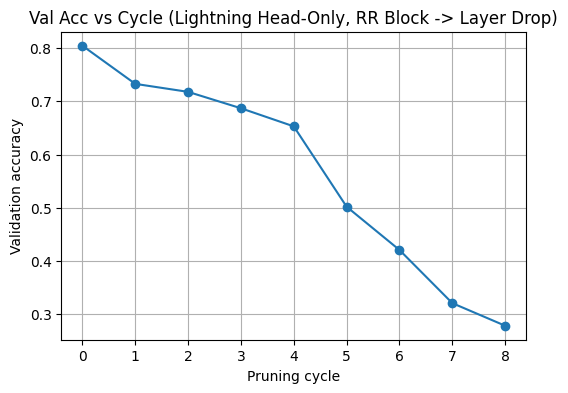

In [ ]:

xs = [c for c,_ in val_acc_history]; ys = [a for _,a in val_acc_history]
plt.figure(figsize=(6,4)); plt.plot(xs, ys, marker='o')
plt.xlabel("Pruning cycle"); plt.ylabel("Validation accuracy")
plt.title("Accuracy vs Pruning Cycle"); plt.grid(True); plt.show()
